# **RES18**

In [0]:
!git clone https://github.com/LEEJ0NGWAN/Scene-Sentiment-Classifier

Cloning into 'Scene-Sentiment-Classifier'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 16883 (delta 11), reused 31 (delta 10), pack-reused 16849
Receiving objects: 100% (16883/16883), 2.49 GiB | 16.41 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Checking out files: 100% (18001/18001), done.


작업 디렉토리로 이동

In [0]:
%cd ./Scene-Sentiment-Classifier/
!ls

[Errno 2] No such file or directory: './Scene-Sentiment-Classifier/'
/content/Scene-Sentiment-Classifier
data  docs  LICENSE  README.md	tools


In [0]:
!rm ./data/horror_test/DarkNamer.exe

rm: cannot remove './data/horror_test/DarkNamer.exe': No such file or directory


In [0]:
from __future__ import print_function, division

import os

import torch
from PIL import Image
from skimage import io
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils import data
import matplotlib.pyplot as plt

dataLoader 구현

In [0]:
class MovieDataLoader(Dataset):
    def __init__(self, root_dir, folder_names, mode, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.folder_names = folder_names
        self.file_list =[]
        for fn in folder_names:
            self.total_dir = os.path.join(self.root_dir, fn)
            self.file_list += os.listdir(self.total_dir)
        self.file_len = len(self.file_list)
        self.train_and_test = folder_names[0].split('_')[1]
        self.genre = ['action', 'horror', 'romance', 'ani2D', 'ani3D', 'sf']
        self.mode = mode

    def __len__(self):
        return self.file_len

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        label = img_name.split('_')[0]
        image = Image.open(os.path.join(self.root_dir+'/'+label+'_'+self.train_and_test, img_name))

        if self.transform:
            image = self.transform(image)

        if self.mode == 'TRAIN':
            return image, self.genre.index(label)

        elif self.mode == 'TEST':
            return image, torch.LongTensor([self.genre.index(label)])

변수 설정

In [0]:
genre = ['action', 'horror', 'romance', 'ani2D', 'ani3D', 'sf']
folder_name = []
train_and_test = ['train', 'test']
folder_name_train = ['action_train', 'horror_train', 'romance_train', 'ani2D_train', 'ani3D_train', 'sf_train']
folder_name_test = ['action_test', 'horror_test', 'romance_test', 'ani2D_test', 'ani3D_test', 'sf_test']
root_dir = './data'

classes = ('action', 'horror', 'romance', 'ani2D', 'ani3D', 'sf')

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

preprocess = transforms.Compose([
    #transforms.Resize(512),
    transforms.ToTensor(),
    #transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CLASS_LEN = 6
BATCH_SIZE = 32
PRINT_PER_BATCH = 100
MODEL_NAME = 'RESNET18'
epochs = 2

데이터 세팅

In [0]:

train_dataset = MovieDataLoader(root_dir, folder_name_train, 'TRAIN', preprocess )
test_dataset = MovieDataLoader(root_dir, folder_name_test ,'TEST',preprocess)
train_data_loader = data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
test_data_loader = data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

net = models.resnet18() # torchvision 에 이미 정의된 모델을 가져옴
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

학습

In [0]:


print('\n===> Training Start')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

if torch.cuda.is_available():
  print('\n===> Training on GPU!')

for epoch in range(epochs):
    print('\n===> epoch %d' % epoch)
    running_loss = 0.0
    n_train_correct, n_total = 0, 0

    for i, data in enumerate(train_data_loader):
        # input 가져오기
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        net.train()
        # 그라디언트 초기화
        optimizer.zero_grad()

        # 전후 학습
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        n_train_correct += (predicted == labels.view(labels.shape[0])).squeeze().sum().item()
        n_total += labels.shape[0]
        train_acc = 100. * n_train_correct/n_total

        if i % PRINT_PER_BATCH == PRINT_PER_BATCH - 1: 
            print('train: [%d, %5d] loss: %.3f accuracy: %.3f' %
                  (epoch + 1, i + 1, loss.item(), train_acc), end = ' ')
            
            train_losses.append(loss.item())
            train_accuracy.append(train_acc)

            running_loss = 0.0

            net.eval();
            n_test_correct, test_loss = 0, 0
            n_test_total = 0

            with torch.no_grad():
                for j, data in enumerate(test_data_loader):
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs, 1)
                    n_test_correct += (predicted == labels.view(labels.shape[0])).squeeze().sum().item()
                    n_test_total += labels.shape[0]
                    test_loss = criterion(outputs, labels.view(-1))
            test_acc = 100. * n_test_correct /  n_test_total

            test_losses.append(test_loss.item())
            test_accuracy.append(test_acc)

            print('test:  loss: %.3f accuracy: %.3f' %
                  (test_loss, test_acc))


===> Training Start

===> Training on GPU!

===> epoch 0
train: [1,   100] loss: 0.050 accuracy: 97.031 test:  loss: 5.643 accuracy: 35.445
train: [1,   200] loss: 0.018 accuracy: 97.375 test:  loss: 4.791 accuracy: 36.517
train: [1,   300] loss: 0.067 accuracy: 97.531 test:  loss: 4.862 accuracy: 38.018
train: [1,   400] loss: 0.020 accuracy: 97.656 test:  loss: 2.476 accuracy: 46.570

===> epoch 1
train: [2,   100] loss: 0.015 accuracy: 97.969 test:  loss: 3.325 accuracy: 29.943
train: [2,   200] loss: 0.071 accuracy: 98.031 test:  loss: 6.289 accuracy: 40.829
train: [2,   300] loss: 0.237 accuracy: 98.042 test:  loss: 8.192 accuracy: 42.163
train: [2,   400] loss: 0.081 accuracy: 98.180 test:  loss: 2.100 accuracy: 34.350


In [0]:
class_correct = list(0. for i in range(CLASS_LEN))
class_total = list(0. for i in range(CLASS_LEN))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = labels.view(labels.shape[0])
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

train accuracy: 98.1796875
validation accuracy: 46.569795140543114


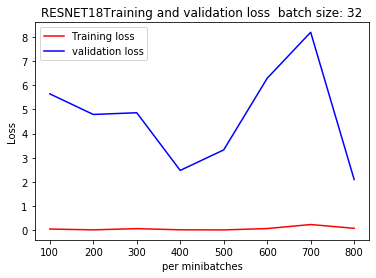

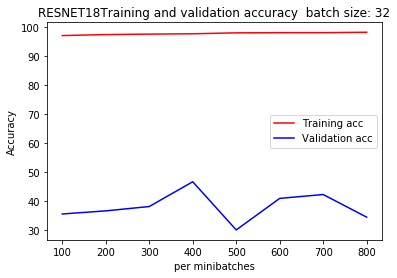

In [0]:
print("train accuracy: " + str(max(train_accuracy)))
print("validation accuracy: " + str(max(test_accuracy)))

per_minibatch = range(PRINT_PER_BATCH, PRINT_PER_BATCH*len(train_losses)+1, PRINT_PER_BATCH)

plt.plot(per_minibatch, train_losses, 'r', label='Training loss')
plt.plot(per_minibatch, test_losses, 'b', label='validation loss')
plt.title(MODEL_NAME + 'Training and validation loss' + '  batch size: ' + str(BATCH_SIZE))
plt.xlabel('per minibatches')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(per_minibatch, train_accuracy, 'r', label='Training acc')
plt.plot(per_minibatch, test_accuracy, 'b', label='Validation acc')
plt.title(MODEL_NAME + 'Training and validation accuracy' + '  batch size: ' + str(BATCH_SIZE))
plt.xlabel('per minibatches')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy of action : 24 %
Accuracy of horror :  2 %
Accuracy of romance : 27 %
Accuracy of ani2D : 72 %
Accuracy of ani3D : 13 %
Accuracy of    sf : 98 %


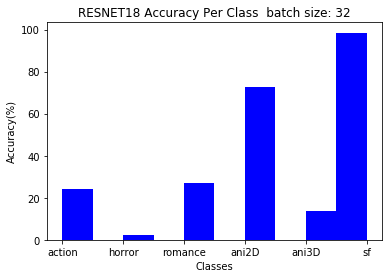

In [0]:
acc_per_class = []
for i in range(CLASS_LEN):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    acc_per_class.append(100 * class_correct[i] / class_total[i])
hist = plt.hist(classes, weights = acc_per_class, color = 'b', linewidth = 1.2)
plt.title(MODEL_NAME + ' Accuracy Per Class'+ '  batch size: ' + str(BATCH_SIZE))
plt.xlabel('Classes')
plt.ylabel('Accuracy(%)')
plt.show()